In [1]:
library(dplyr)
library(stringr)
library(ggplot2)
library(Seurat) 
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(ggbeeswarm)
library(ggpubr)
library(shazam)
library(alakazam)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite



To cite the SHazaM package in publications, please use:

  Gupta N, Vander Heiden J, Uduman M, Gadala-Maria D, Yaari G,
  Kleinstein S (2015). “Change-O: a toolkit for analyzing large-scale B
  cell immunoglobulin repertoire sequencing data.” 

In [2]:
group.col=c('Alum-pSer'='#0072B2','SMNP'='#E69F00','Alum-pSer/SMNP'='#009E73')
my.comparison = list(c('Alum-pSer','SMNP'),c('SMNP','Alum-pSer/SMNP'),c('Alum-pSer','Alum-pSer/SMNP'))
Axis_themes <- theme(plot.title = element_text(size = 8,hjust=0.5),
                     axis.title = element_text(size = 8),
                     axis.text = element_text(size = 8,color='black'),
                     axis.text.x = element_text(size = 8,angle=45,hjust=1),                     
                     legend.text = element_text(size = 8),
                     legend.title = element_text(size = 8),
                     legend.key.size = unit(.3, 'cm'),
                     strip.text.x = element_text(size = 8),
                     strip.background = element_rect(fill=NA,linewidth=.3,color='black'),
                     axis.line = element_line(linewidth = .3),
                     axis.ticks = element_line(linewidth = 0.3))

In [3]:
bcr = read.csv('bcr_output/SVEU_VDJsequences_CDR3.csv',row.names=1)
dim(bcr)
head(bcr,1)

[1] 44190    87

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,v_call.y,j_call.y,sequence_alignment.y,germline_alignment.y,junction.y,junction_aa.y,locus.y,junction_length.y,mu_count.y,lightchain
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,W13_11_AAACCTGAGATCACGG-1,GGGGAGCTCTGGGAGAGGAGCCCAGCCCTGGAAGTCCACAGTGTTCCATTCGGTGATCAGCACAGAACACAGAGGACTCACCATGGAGTCTGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAGAGGTGTCCAGTGTGAGGTGCAACTGGTGGAGTCTGGAGGGGGCTTGGTCCAGCCTGGGGGGTCCCTGAGACTCTCCTGCGTAGTCTCTGGATTCACCTTCAGTAGCTATGGCATGAGCTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCTCATACATTAATAATGGTGGTTCTAGCACATACTACGCAGAATCCGTGAAGGGCCGATTCACCCTGTCCAGAGACAACTCAAAGAACACGCTCTCCCTGCAAATGAACAGCCTGAGACCTGAGGACACGGCCGTGTATTACTGTGCGAAAGATCATGATGATACTGGTACTTATTACCCTCTCCTTGACTTCTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATGCCCCGTTGGATACAAACGAAGTGGCCGTT,FALSE,TRUE,IGHV3-AFE*01_S4619,"IGHD3-14*01,IGHD3-16*01,IGHD3-J16*01","IGHJ4*01,IGHJ4-3*01",GAGGTGCAACTGGTGGAGTCTGGAGGG...GGCTTGGTCCAGCCT...GGGGGGTCCCTGAGACTCTCCTGCGTAGTCTCT...GGATTCACCTTC............AGTAGCTATGGCATGAGCTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCTCATACATTAATAATGGT......GGTTCTAGCACATACTACGCAGAATCCGTGAAG...GGCCGATTCACCCTGTCCAGAGACAACTCAAAGAACACGCTCTCCCTGCAAATGAACAGCCTGAGACCTGAGGACACGGCCGTGTATTACTGTGCGAAAGATCATGATGATACTGGTACTTATTACCCTCTCCTTGACTTCTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCTGGAGGA...GGCTTGGTCCAGCCT...GGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCT...GGATTCACCTTC............AGTAGCTATGGCATGAGCTGGGTCCGCCAGGCTCCAGGGAAGGGGCTGGAGTGGGTCTCATACATTAGTAATGGT......GGTGGTAGCACATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACTCAAAGAACACGCTCTCCCTGCAAATGAACAGCCTGAGAGCTGAGGACACGGCCGTGTATTACTGTGCGAAAGANNNNNNNNATAGTGGTAGTTATTACNNNNNNNTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAG,TGTGCGAAAGATCATGATGATACTGGTACTTATTACCCTCTCCTTGACTTCTGGG,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,YES


In [4]:
fil.bcr = bcr %>% filter(c_call %in% c('IGHM','IGHA',paste0('IGHG',seq(1,4))),c_call_ident>95,
                         !rev_comp,!stop_codon,productive,vj_in_frame,
                         group%in%c('pSer:alum + SMNP','pSer:alum','SMNP')) 
fil.bcr$group[fil.bcr$group=='pSer:alum'] = 'Alum-pSer'
fil.bcr$group[fil.bcr$group=='pSer:alum + SMNP'] = 'Alum-pSer/SMNP'
fil.bcr$group=factor(fil.bcr$group,levels=c('Alum-pSer','SMNP','Alum-pSer/SMNP'))
fil.bcr$week = paste('Week',fil.bcr$week,sep=' ')
fil.bcr$week=factor(fil.bcr$week,levels=c('Week 6','Week 13','Week 27'))
dim(fil.bcr)

[1] 29780    87

In [5]:
# only look at week 6 
fil.bcr = fil.bcr %>% filter(week == 'Week 6') %>% 
# create columns that will be used for plotting 
mutate(CLONE = clone_id,mouse.id=nhp_id) %>%
mutate(IGH_GERMLINE_V_CALL = v_call, IGL_V_CALL = ifelse(is.na(v_call.x),v_call.y,v_call.x)) %>%
# add recovery information 
mutate(IGH_recovery = as.numeric(!is.na(germline_v_call)), 
                   IGL_recovery = as.numeric(!is.na(v_call.x))+as.numeric(!is.na(v_call.y)) ) %>%
mutate(recovery = IGH_recovery*2 + as.numeric(IGL_recovery>0)) 
dim(fil.bcr)

[1] 8913   94

In [6]:
colnames(fil.bcr)

[1] "sequence_id"               "sequence"                 
 [3] "rev_comp"                  "productive"               
 [5] "v_call"                    "d_call"                   
 [7] "j_call"                    "sequence_alignment"       
 [9] "germline_alignment"        "junction"                 
[11] "junction_aa"               "CDR3_IGH_Length"          
[13] "v_cigar"                   "d_cigar"                  
[15] "j_cigar"                   "stop_codon"               
[17] "vj_in_frame"               "locus"                    
[19] "junction_length"           "np1_length"               
[21] "np2_length"                "v_sequence_start"         
[23] "v_sequence_end"            "v_germline_start"         
[25] "v_germline_end"            "d_sequence_start"         
[27] "d_sequence_end"            "d_germline_start"         
[29] "d_germline_end"            "j_sequence_start"         
[31] "j_sequence_end"            "j_germline_start"         
[33] "j_germline_end"            "v_score"                  
[35] "v_identity"                "v_support"                
[37] "d_score"                   "d_identity"               
[39] "d_support"                 "j_score"                  
[41] "j_identity"                "j_support"                
[43] "fwr1"                      "fwr2"                     
[45] "fwr3"                      "fwr4"                     
[47] "cdr1"                      "cdr2"                     
[49] "cdr3"                      "c_call"                   
[51] "clone_id"                  "c_call_ident"             
[53] "week"                      "reaction"                 
[55] "multi_id"                  "multi_classification"     
[57] "set"                       "hashid"                   
[59] "nhp_id"                    "lymph_node"               
[61] "group"                     "germline_alignment_d_mask"
[63] "germline_v_call"           "germline_d_call"          
[65] "germline_j_call"           "mu_count"                 
[67] "sequence.x"                "v_call.x"                 
[69] "j_call.x"                  "sequence_alignment.x"     
[71] "germline_alignment.x"      "junction.x"               
[73] "junction_aa.x"             "locus.x"                  
[75] "junction_length.x"         "mu_count.x"               
[77] "sequence.y"                "v_call.y"                 
[79] "j_call.y"                  "sequence_alignment.y"     
[81] "germline_alignment.y"      "junction.y"               
[83] "junction_aa.y"             "locus.y"                  
[85] "junction_length.y"         "mu_count.y"               
[87] "lightchain"                "CLONE"                    
[89] "mouse.id"                  "IGH_GERMLINE_V_CALL"      
[91] "IGL_V_CALL"                "IGH_recovery"             
[93] "IGL_recovery"              "recovery"

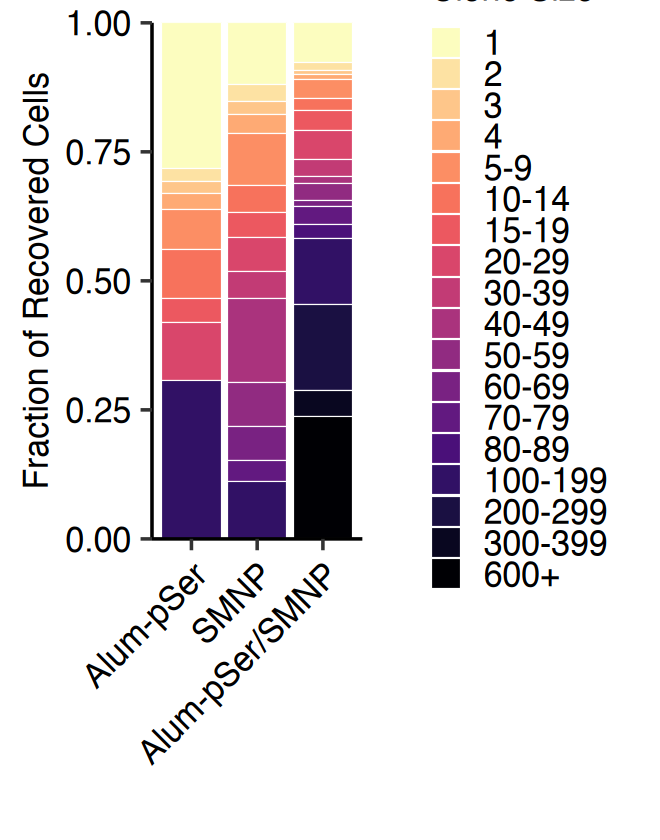

In [9]:
options(repr.plot.height=2.8,repr.plot.width=2.2,repr.plot.res=300)

metadata = fil.bcr  

count <- metadata %>% count(group,CLONE,name = 'seq_count')
metadata$clonal.size <- count$seq_count[match(metadata$CLONE, count$CLONE)]

metadata <- metadata %>%
  mutate(bin = cut(clonal.size, include.lowest = TRUE,
                   breaks = c(0, 1, 2, 3, 
                              seq(4, 20, 5),
                              seq(29, 100, 10),
                              seq(199, 550, 100), 10000),
                   labels = c(1,2,3,4, 
                              paste(seq(5, 15, 5), seq(9, 19, 5), sep = "-"), 
                              paste(seq(20, 90, 10), seq(29, 99, 10), sep = "-"),
                              paste(seq(100,400, 100), seq(199, 499, 100), sep = "-"), "600+")
                  ))

metadata %>%
ggplot(aes(x = group, fill = bin)) + theme_classic() +
geom_bar(position = 'fill', color = 'white', linewidth = 0.1) +
labs(x = '', y = 'Fraction of Recovered Cells', fill = 'Clone Size') +
scale_fill_viridis(discrete = TRUE, direction = -1, option = 'magma', na.value = 'grey') +
guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.2, ncol = 1)) +
scale_y_continuous(expand = c(0, 0)) +
Axis_themes

out = 'figures/SVEU_fig/barplot_clone_size.pdf'
ggsave(out,device='pdf', height = 2.8, width = 2.2,
       dpi = 300,useDingbats = FALSE)


In [10]:
table(metadata$group)


     Alum-pSer           SMNP Alum-pSer/SMNP 
           650           1913           6350 

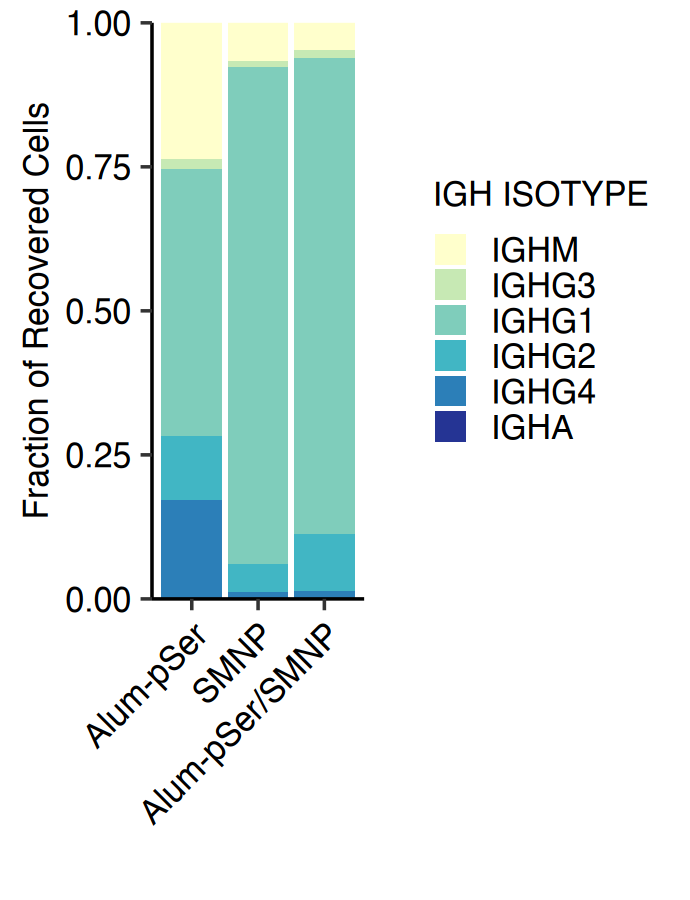

In [132]:
options(repr.plot.height=3, repr.plot.width=2.3,repr.plot.res=300)
metadata = fil.bcr
metadata$c_call = factor(metadata$c_call,levels=c('IGHM','IGHG3','IGHG1','IGHG2','IGHG4','IGHA'))

metadata %>% filter(c_call!='NA') %>% 
ggplot(aes(x=group, fill=c_call)) + theme_classic() + 
geom_bar(position='fill') + 
scale_fill_brewer(palette = 'YlGnBu',direction=1,na.value="grey")+
labs(x='',y='Fraction of Recovered Cells',fill='IGH ISOTYPE') + 
scale_y_continuous(expand = c(0,0)) +
Axis_themes

# out = 'md39/figures/fig3/CSR_heavy.pdf'
# ggsave(out,device='pdf', height = 7, width = 4,
#        dpi = 300,useDingbats = FALSE)


In [ ]:
# public clone

In [152]:
# write.table(fil.bcr,'bcr_output/SVEU_before_public_clone.tab', 
#             quote = FALSE, row.names = FALSE, sep = '\t')

DefineClones.py -d SVEU_before_public_clone.tab -o SVEU_after_public_clone.tab --act set --model aa --norm len --format changeo --sf junction --vf v_call --jf j_call --sym avg --link single --dist 0.1

In [7]:
library(ggraph)
library(igraph)


Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

    geometry


Warning message:
“package ‘igraph’ was built under R version 4.3.3”

Attaching package: ‘igraph’


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [62]:
public.bcr.single = read.csv('bcr_output/SVEU_after_public_clone_single.tab',sep='\t') %>% rename(public_clone=CLONE) 
# changeo captilize all colnames, change to airr format
colnames(public.bcr.single) = tolower(colnames(public.bcr.single))
public.bcr.single$group=factor(public.bcr.single$group,levels=c('alum-pSer','SMNP','alum-pSer/SMNP'))
public.bcr.single$week = paste0('Week',' ',public.bcr.single$week)
public.bcr.single$week=factor(public.bcr.single$week,levels=c('Week 6','Week 13','Week 27'))

In [63]:
# add private clone info (single linkage 0.07 dist)
single = read.csv('bcr_output/SVEU_after_private_clone_single.tab',sep='\t')
public.bcr.single$private_clone = single$clone_id[match(public.bcr.single$sequence_id,single$sequence_id)]
head(public.bcr.single,2)

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,lymph_node,group,germline_alignment_d_mask,germline_v_call,germline_d_call,germline_j_call,mu_count,lightchain,public_clone,private_clone
,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>
1,W13_12_AGCGGTCAGTAGGCCA-1,TGGGGAGCTCTGAGAGAGGAGCCTTAGCCCTGGGTTCCAAGGCACTTCCACTTGGGGATCAGCCCTGAACACAGAAGACCCACCATGGAGTTGGGGCTGAGCTGGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCAGTGTGAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTCCAGCCTGGAGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTTCAGTGACTACTACATGAGCTGGGTCCGCCAGGCTCCGGGAAAGGGGCTGGAGTGGGTCTCATCCATTAGTAGTGCTAGTAGTTACATATACTACGCTGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCGCTGTCTCTGCAAATGAACAGCCTGAAAACCGAGGACACGGCCGTGTATTACTGTACTAGGCACCGCTACGGCCACTTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATGCCCCGTTGGATACAAACGAAGTGGCCGTT,FALSE,TRUE,IGHV3-NL_1*01_S3947,"IGHD5-31*01,IGHD5-33*01","IGHJ4*01,IGHJ4-3*01",GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTCCAGCCT...GGAGGGTCCCTGAGACTCTCCTGTGCAGCCTCT...GGATTCACCTTC............AGTGACTACTACATGAGCTGGGTCCGCCAGGCTCCGGGAAAGGGGCTGGAGTGGGTCTCATCCATTAGTAGTGCT......AGTAGTTACATATACTACGCTGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCGCTGTCTCTGCAAATGAACAGCCTGAAAACCGAGGACACGGCCGTGTATTACTGTACTAGGCACCGCTACGGCCACTTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAG,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTCCAGCCT...GGAGGGTCCCTGAGACTCTCCTGTGCAGCCTCT...GGATTCACCTTC............AGTGACTACTACATGAGCTGGGTCCGCCAGGCTCCGGGAAAGGGGCTGGAGTGGGTCTCATCCATTAGTAGTGCT......AGTAGTTACATATACTACGCTGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCGCTGTCTCTGCAAATGAACAGCCTGAAAACCGAGGACACGGCCGTGTATTACTGTACTAGNNNNNGCTACGGNNACTTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAG,TGTACTAGGCACCGCTACGGCCACTTTGACTACTGGG,⋯,R iLN,SMNP,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTCCAGCCT...GGAGGGTCCCTGAGACTCTCCTGTGCAGCCTCT...GGATTCACCTTC............AGTGACTACTACATGAGCTGGGTCCGCCAGGCTCCGGGAAAGGGGCTGGAGTGGGTCTCATCCATTAGTAGTGCT......AGTAGTTACATATACTACGCTGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCGCTGTCTCTGCAAATGAACAGCCTGAAAACCGAGGACACGGCCGTGTATTACTGTACTAGNNNNNNNNNNNNNNACTTTGACTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAG,IGHV3-NL_1*01_S3947,IGHD5-31*01,IGHJ4*01,0,YES,1,43
2,W13_12_AACGTTGCAGACAAAT-1,GAGCTCTGGGAGAGGAGCCACAGCCCCGGGATTCCCAGCTGTCTCCACTTGGTCATGAACACTGAACTCAGAAGACGCACCATGGAGTTTGTGCTGAGTTTGGTTTTCCTTGTTGCTATTTTAAAAGGTGTCCGGTGTGACGTGCAGCTGGTGGAGTCGGGGGGAGGCTTGGTAAAGCCTGGGGGGTCCCTGAGACTCTCTTGTGTGGCCTCTGGGTTCACCTTCAGTACCTACGAAATGCACTGGGTCCGCCAGGCTCCAGGAAAGGGTCTGGAGTGGGTCTCAGTTATTAGTGATAGTGGTGGTACCACATACTACGCAGACTCCGTGAAGGGCCGATTCACCATCTCCAGAGACAACGCCCAGAACTCAGTGTTTCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCCGTGTATTACTGTGCTAGACAGGTAGCGGCAGCTGGAGGCTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATGCCCCGTTGGATACAAACGAAGTGGCCGTT,FALSE,TRUE,IGHV3-73*01,"IGHD6-24*01,IGHD6-36*01","IGHJ4*01,IGHJ4-3*01,IGHJ4-3*01_S9191",GACGTGCAGCTGGTGGAGTCGGGGGGA...GGCTTGGTAAAGCCT...GGGGGGTCCCTGAGACTCTCTTGTGTGGCCTCT...GGGTTCACCTTC............AGTACCTACGAAATGCACTGGGTCCGCCAGGCTCCAGGAAAGGGTCTGGAGTGGGTCTCAGTTATTAGTGATAGT......GGTGGTACCACATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCCAGAACTCAGTGTTTCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCCGTGTATTACTGTGCTAGACAGGTAGCGGCAGCTGGAGGCTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAG,GACGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTAAAGCCT...GGGGGGTCCCTGAGACTCTCTTGTGTAGCCTCT...GGGTTCACCTTC............AGTAGCTACGAAATGCACTGGGTCCGCCAGGCTCCAGGAAAGGGTCTGGAGTGGGTCTCAGTTATTAGTGAAAGT......GGTGGTACCACATACTACGCAGACTCCGTGAAG...GGCCGATTCACCATCTCCAGAGACAACGCCAAGAACTCACTGTTTCTGCAAATGAACAGCCTGAGAGCCGAGGACACGGCCGTGTATTACTGTACTAGANNNNTAGCGGCAGCTGGANNCTACTGGGGCCAGGGAGTCCTGGTCACCGTCTCCTCAG,TGTGCTAGACAGGTAGCGGCAGCTGGAGGCTACTGGG,⋯,L iLN,SMNP,GACGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTAAAGCCT...GGGGGGTCCCTGAGACTCTCTTGTGTAGCCTCT...GGGTTCACCTTC............AGTAGCTACGAAATGCACTGGGTCCGCCAGGCTCCAGGAAAGGGTCTGGAGTGGGTCTCAGTTATTAGTGAAAGT......GGTGGTA

In [64]:
# check if any private clones are present in more than one public clones 
public.bcr.single %>% count(private_clone, public_clone) %>% count(private_clone) %>% filter(n>1)

private_clone,n
<int>,<int>


In [65]:
# only look at public clones on Week 6
metadata = public.bcr.single %>% filter(week == 'Week 6')

# label private and meta clone 
metadata$private = paste0('P',metadata$private_clone)
metadata$meta = paste0('M',metadata$public_clone)

# collapse private and meta clone 
temp.df = metadata %>% group_by(meta,group,private) %>% summarize(ncell.clone=n()) %>% 
mutate(from = meta, to = paste(meta,private,sep='.')) %>% ungroup()

temp.df = merge(temp.df, temp.df %>% count(meta, name = 'nclone'), by = 'meta')
metaclones = temp.df 

# create first hiarchy
df.pub = temp.df %>% filter(meta %in% metaclones$meta) 
v1 = df.pub %>% group_by(meta) %>% summarize(ncell.meta = sum(ncell.clone)) %>% 
rename('name'='meta','count'='ncell.meta') %>% 
mutate(group=ifelse(name %in% metaclones$meta,'_Metaclone','_Metaclone1'),size=0)

# second hiarchy 
v2 = df.pub %>% select(to, ncell.clone, group) %>% rename(name=to, count=ncell.clone) %>% mutate(size=count)

# combine 
edges = rbind(df.pub %>% select(from, to))
vertices = rbind(v1,v2)
vertices$size.trans = log2(vertices$size+1) #sqrt(vertices$size)
vertices$group = factor(vertices$group, levels=c('_Metaclone','alum-pSer','SMNP','alum-pSer/SMNP'))

`summarise()` has grouped output by 'meta', 'group'. You can override using the
`.groups` argument.


[1] 46399


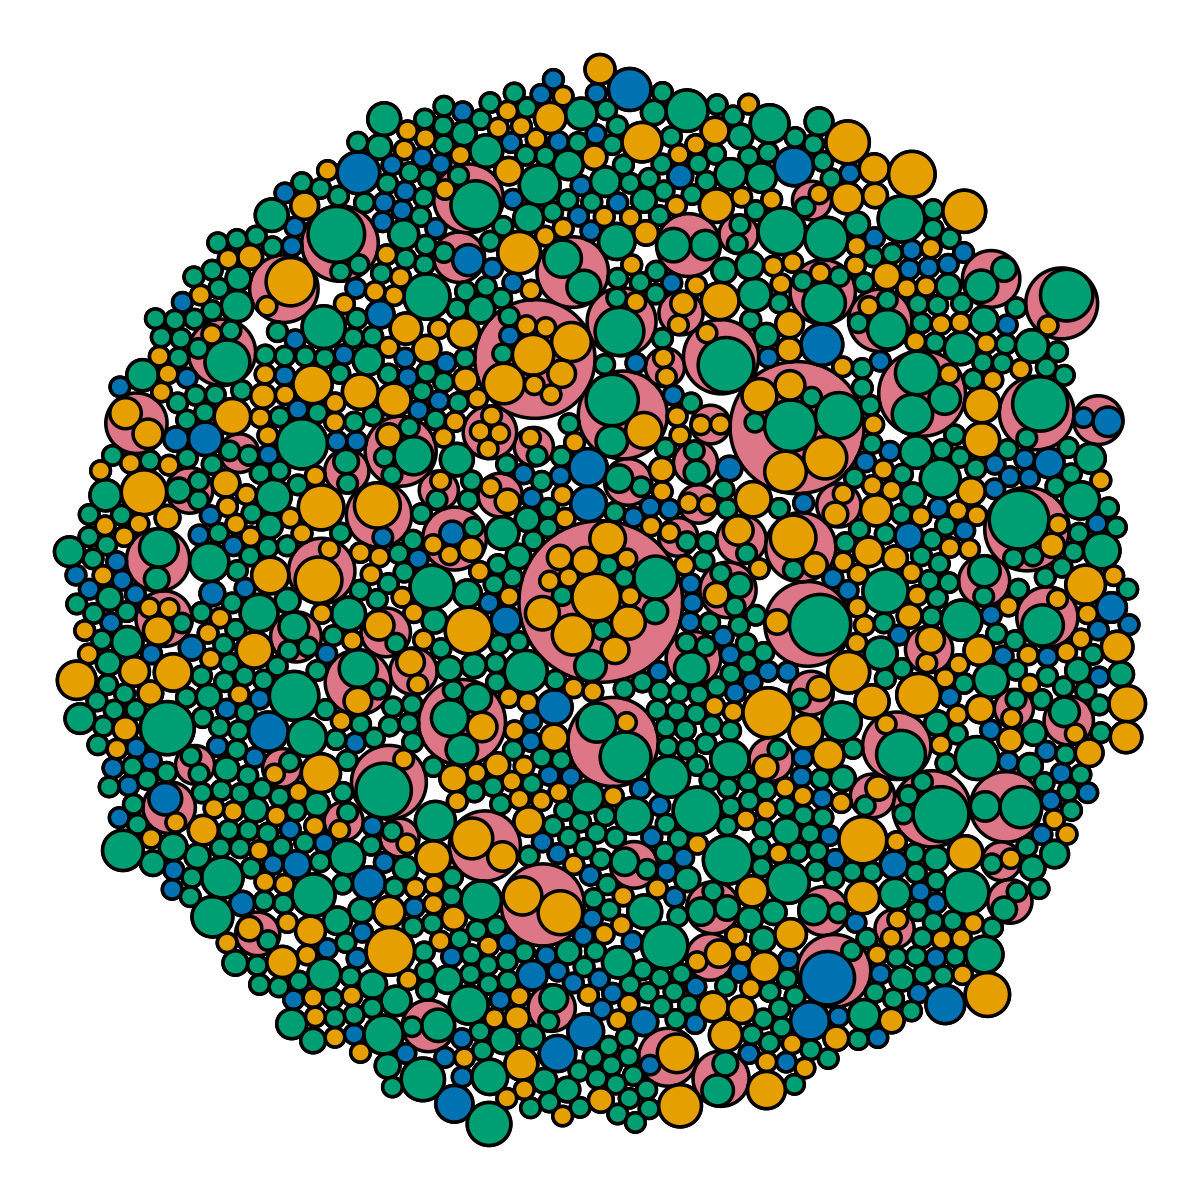

In [68]:
# Make the plot
options(repr.plot.height=4, repr.plot.width=4,repr.plot.res=300)

n=sample(1:50000,size = 1,replace = FALSE)
print(n)
#set.seed(n)
# set.seed(476) 
set.seed(28527)

mygraph <- graph_from_data_frame(edges, vertices=vertices%>% arrange(sample(row_number())) )

col = c('alum-pSer'='#0072B2','SMNP'='#E69F00','alum-pSer/SMNP'='#009E73',
        'alum-pSer1'=alpha('#0072B2',0.5),'SMNP1'=alpha('#E69F00',0.5),'alum-pSer/SMNP1'='#acd98d',
        '_Metaclone'=alpha('#dd7788',1),'_Metaclone1'= NA ) # #ffd94a

# Make the plot
ggraph(mygraph, layout = 'circlepack',weight = size.trans) +  #, sort.by = size
  geom_node_circle(aes(fill=factor(group,
                                   levels=c('_Metaclone1','_Metaclone','alum-pSer1','alum-pSer','alum-pSer/SMNP','SMNP1','alum-pSer/SMNP1','SMNP'))),linewidth=0.3)+
  theme_void() +
scale_fill_manual(values = col, na.value = 'red') +
guides(fill='none')

# out = 'figures/SVEU_fig/metaclone_circlepack.pdf'
# ggsave(out,device='pdf', height = 4, width = 4,
#        dpi = 300,useDingbats = FALSE)

Warning message in geom_col(stat = "identity", color = "black", linewidth = 0.1):
“Ignoring unknown parameters: `stat`”


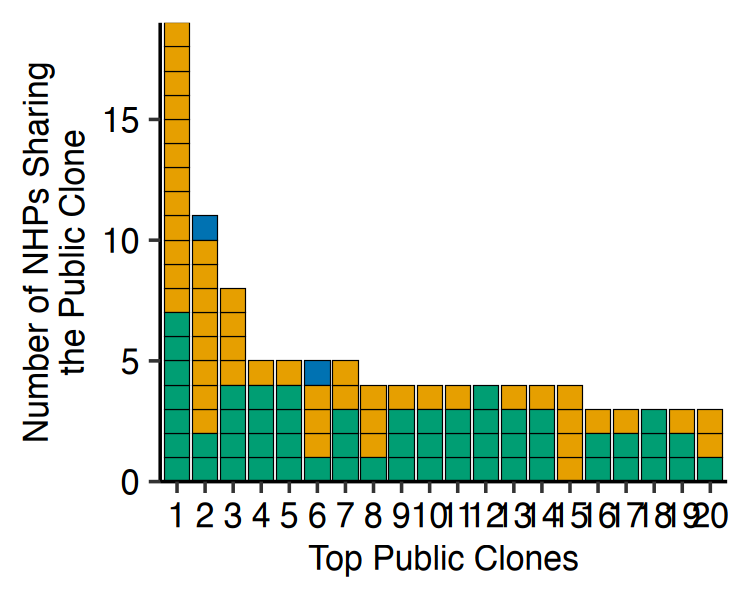

In [22]:
# barplot 
options(repr.plot.height=2, repr.plot.width=2.5,repr.plot.res=300)
col = c('alum-pSer'='#0072B2','SMNP'='#E69F00','alum-pSer/SMNP'='#009E73',
        'alum-pSer1'=alpha('#0072B2',0.8),'SMNP1'=alpha('#E69F00',0.5),'alum-pSer/SMNP1'='#acd98d',
        '_Metaclone'=alpha('#dd7788',1),'_Metaclone1'='black')

df4gg = df.pub %>% 
group_by(meta) %>% mutate(ncell.meta=sum(ncell.clone),nclone=n()) %>% 
arrange(desc(nclone),desc(ncell.meta)) %>% mutate(y=1)

rank = df.pub %>% count(meta, name='nclone') %>% arrange(desc(nclone))%>% mutate(rank = seq(1:nrow(.)))
df4gg$rank = rank$rank[match(df4gg$meta, rank$meta)]

df4gg %>% filter(rank<21) %>%
ggplot(aes(x=factor(rank),y=1, fill=group)) + theme_classic()+ 
geom_col(stat='identity', color='black', linewidth=0.1) + 
scale_fill_manual(values = col) + 
scale_y_continuous(expand=c(0,0)) +
labs(x='Top Public Clones',y='Number of NHPs Sharing\nthe Public Clone') +
Axis_themes + 
theme(legend.position = 'none',
      axis.text.x = element_text(angle=0, hjust=0.5))

out = 'figures/SVEU_fig/metaclone_barplot.pdf'
ggsave(out,device='pdf', height = 2, width = 2.5,
       dpi = 300,useDingbats = FALSE)

In [107]:
# only look at public clones on Week 6
metadata = public.bcr.single %>% filter(week == 'Week 6')

# find public clones
pub.clones = metadata %>% 
# aggregate cells into private clones
count(group,public_clone,private_clone, name = 'ncell.clone') %>% 
# aggregate clones into public clones
count(public_clone, name = 'nclone') %>% 
filter(nclone>=2) 

df.pub = metadata %>% 
# only keep clones that are in a public clone
filter(public_clone %in% pub.clones$public_clone) %>%
# aggregate cells into private clones
count(public_clone,group,private_clone, name = 'ncell.clone') %>% 
# create index column
mutate(index = ifelse(group=='alum-pSer', 3, ifelse(group=='SMNP',4,5))) 

# create label for each public clone
meta.type = df.pub %>% group_by(public_clone, index) %>% slice(1) %>% 
group_by(public_clone) %>% summarize(label = sum(index))

donut.df = merge(indexed.meta,meta.type, by='public_clone')

In [112]:
table(vertices$group)


    _Metaclone      alum-pSer           SMNP alum-pSer/SMNP 
          1199            222            400            736 

In [126]:
df4gg = vertices %>% filter(group != '_Metaclone') %>% 
mutate(meta = str_split_i(name,'\\.',1),clone = str_split_i(name,'\\.',2)) 
public = df4gg %>% 
count(meta, clone, group) %>% count(meta) %>% filter(n>1)

label.df = df4gg %>% filter(meta %in% public$meta) %>% 
count(meta, clone, group) %>% 
count(meta,group) %>%
group_by(meta) %>% summarise(label = paste0(group, collapse = ' & '))

df4gg$label = label.df$label[match(df4gg$meta, label.df$meta)]

In [138]:
donut.df = df4gg %>% filter(!is.na(label)) %>% count(meta,label,name='nclone') %>% count(label,name='nmeta')
donut.df$label = factor(donut.df$label, levels=c('alum-pSer','SMNP','alum-pSer/SMNP','alum-pSer & SMNP','SMNP & alum-pSer/SMNP','alum-pSer & alum-pSer/SMNP','alum-pSer & SMNP & alum-pSer/SMNP'))
donut.df = donut.df %>% arrange(label)
# Compute the cumulative percentages (top of each rectangle)
donut.df$ymax <- cumsum(donut.df$nmeta)
# Compute the bottom of each rectangle
donut.df$ymin <- c(0, head(donut.df$ymax, n=-1))

donut.df$textPosition <- (donut.df$ymax + donut.df$ymin) / 2
donut.df$text <- paste0(donut.df$nmeta)
donut.df

label,nmeta,ymax,ymin,textPosition,text
<fct>,<int>,<int>,<dbl>,<dbl>,<chr>
alum-pSer,1,1,0,0.5,1
SMNP,16,17,1,9.0,16
alum-pSer/SMNP,25,42,17,29.5,25
alum-pSer & SMNP,3,45,42,43.5,3
SMNP & alum-pSer/SMNP,39,84,45,64.5,39
alum-pSer & alum-pSer/SMNP,2,86,84,85.0,2
alum-pSer & SMNP & alum-pSer/SMNP,2,88,86,87.0,2


In [134]:
, 
                  labels=c('3'='Alum-pSer','4'='SMNP','5'='Alum-pSer/SMNP',
                           '7'='Alum-pSer & SMNP','8'='SMNP & Alum-pSer/SMNP',
                           '9'='Alum-pSer & Alum-pSer/SMNP','12'='All')

[1] "SMNP"                              "SMNP & alum-pSer/SMNP"            
[3] "alum-pSer"                         "alum-pSer & SMNP"                 
[5] "alum-pSer & SMNP & alum-pSer/SMNP" "alum-pSer & alum-pSer/SMNP"       
[7] "alum-pSer/SMNP"

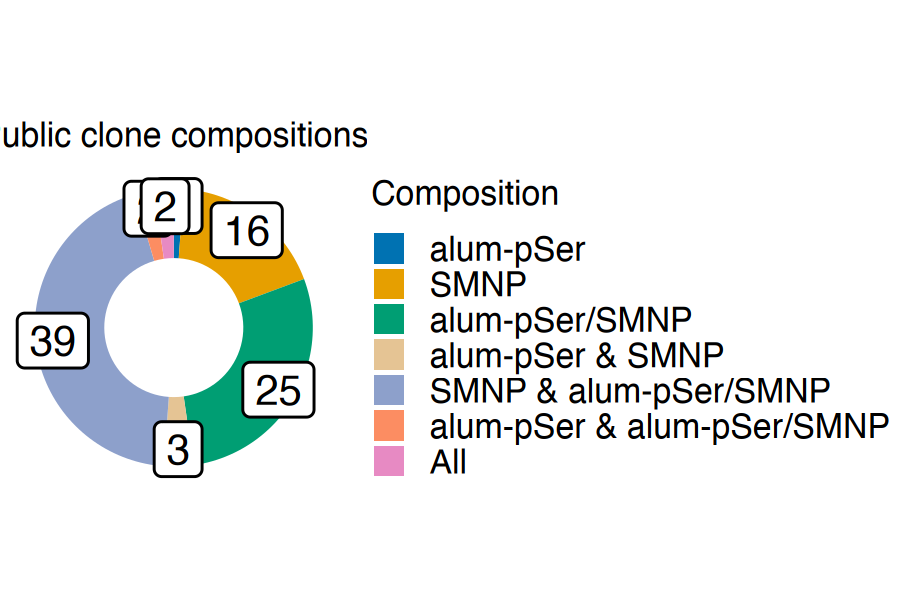

In [141]:
options(repr.plot.height=2, repr.plot.width=3,repr.plot.res=300)

group.col = c('alum-pSer'='#0072B2','SMNP'='#E69F00','alum-pSer/SMNP'='#009E73',
              'alum-pSer & SMNP' = brewer.pal(7, 'Set2')[7],
              'alum-pSer & alum-pSer/SMNP'=brewer.pal(7, 'Set2')[2],
              'SMNP & alum-pSer/SMNP' = brewer.pal(7, 'Set2')[3],
              'alum-pSer & SMNP & alum-pSer/SMNP'=brewer.pal(7, 'Set2')[4])


donut.df %>% 
ggplot(aes()) + 
geom_rect(aes(ymax=ymax,ymin=ymin,xmax=4, xmin=2,fill=factor(label))) +
xlim(c(0, 4)) +
labs(title='Public clone compositions',fill='Composition')+
coord_polar(theta="y") +
geom_label(x=3.5, aes(y=textPosition, label=text), size=3.5) +
scale_fill_manual(values = group.col, labels=c('alum-pSer & SMNP & alum-pSer/SMNP'='All')) +
theme_void() +
theme(legend.text = element_text(size =8),
     legend.title = element_text(size = 8),
     legend.key.size = unit(.3, 'cm'),
      plot.title = element_text(size = 8,hjust=0.5),
     )
out = 'figures/SVEU_fig/metaclone_donutplot.pdf'
ggsave(out,device='pdf', height = 2, width = 3,
       dpi = 300,useDingbats = FALSE)

In [23]:
# check if there are private clones that are grouped into different metaclones 
metadata %>% group_by(group, nhp_id, private_clone, public_clone) %>% 
summarise(ncell.meta.clone=n()) %>% mutate(nmeta.clone=sum(ncell.meta.clone)) %>%
group_by(group, nhp_id, private_clone) %>% mutate(nmeta.clone = n()) %>% filter(nmeta.clone > 1)

`summarise()` has grouped output by 'group', 'nhp_id', 'private_clone'. You can
override using the `.groups` argument.


group,nhp_id,private_clone,public_clone,ncell.meta.clone,nmeta.clone
<fct>,<chr>,<int>,<int>,<int>,<int>


In [26]:
# only look at public clones on Week 6
metadata = public.bcr.single %>% filter(week == 'Week 6')

# find public clones (private clone count > 1)
public.clones = metadata %>% count(group, public_clone, private_clone,name = 'ncell.clone') %>% 
count(group, public_clone, name = 'nclone.meta') %>% filter(nclone.meta>1)

# aggregate to private clones first 
metadata %>% count(group, public_clone, private_clone,name = 'ncell.clone') %>% 
# annotate public clones
mutate(is.public = ifelse(public_clone %in% public.clones$public_clone, 1, 0)) %>% 
# calculate fraction 
group_by(group) %>% summarise(frac = sum(is.public)/n())

group,frac
<fct>,<dbl>
alum-pSer,0.01801802
SMNP,0.20000000
alum-pSer/SMNP,0.14809783


In [ ]:
# what fraction of clnones are in public? 
metadata = srat@meta.data %>% filter(CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')

# find public clones (private clone count > 1)
public.clones = metadata %>% count(Group, META_CLONE, CLONE,name = 'ncell.clone') %>% 
count(Group, META_CLONE, name = 'nclone.meta') %>% filter(nclone.meta>1)

# aggregate to private clones first 
metadata %>% count(Group, META_CLONE, CLONE,name = 'ncell.clone') %>% 
# annotate public clones
mutate(is.public = ifelse(META_CLONE %in% public.clones$META_CLONE, 1, 0)) %>% 
# calculate fraction 
group_by(Group) %>% summarise(frac = sum(is.public)/n())


In [142]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.5

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] C/UTF-8/C/C/C/C

time zone: Asia/Shanghai
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] igraph_2.1.2       ggraph_2.1.0       alakazam_1.3.0     shazam_1.2.0      
 [5] ggpubr_0.6.0       ggbeeswarm_0.7.2   ggrepel_0.9.5      viridis_0.6.5     
 [9] viridisLite_0.4.2  RColorBrewer_1.1-3 Seurat_5.0.1       SeuratObject_5.0.1
[13] sp_2.1-3           ggplot2_3.5.1      stringr_1.5.1      dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1] RcppAnnoy_0.0.22            splines_4.3.2              
  [3] later_1.3.2              